# Before Doing Anything Select the `SONDE` kernel (top right corner)

# Reading and Analysing Data from Windsonde Files 

## Contents

0. [Introduction](#introduction)
2. [Loading normal processed sounding files](#sec1)
3. [Making some simple plots](#sec2)
4. [Making skew-T log-P diagrams](#sec3)
5. [Digging Deeper into the Data](#sec4)

## Introduction <a name="introduction"></a>

Hello there,
    
This is a Jupyter notebook, designed to give you a bit of a tutorial with your analysis of the Boundary Layer using a WindSonde as a part of the Environmental Science Field Skills & Advanced Environmental Science Field and Research Skills courses. It will cover how to read a file containing data from a Windsond, and then how to go about making some plots using the data. 

[Windsond](http://windsond.com/) are a seller of radiosondes and other equipment for profiling the atmosphere. 

Each sond consists of a set of pressure, temperature, humidity and GPS (from which location and wind speed and direction are derived) sensors.

For full details about the sond hardware please check the specification sheet [here](http://windsond.com/windsond_catalog_Feb2019.pdf)

Each sond is referred to by its serial number (a string of 4-5 numbers/characters).

Each sond profile has data stored in series of different text files. Which you use depends on the level of processing, quality control and format you desire for your application. A typical filename of a processed file will look like this:

    2021-03-14_1145.sounding.csv

The date and time are indicative of the moment when the sond was activated. 

The notebook is split into four main data analysis sections:
* Loading a processed sounding file into Python
* Creating a simple plot
* Creating skew-T log-P diagram
* Digging Deeper into the Raw Data

This code has been tested using Jupyter Notebooks, running Python 3.7 on a Mac and the course's Jupyter Hub server. Individual package versions are written next to the package name when they have been imported.

Please send any questions to Neely on Teams in the 2021_HELP! section.

## Loading Sounding Files <a name="sec1"></a>

This section of the notebook concerns loading in the normal sounding files data into pandas dataframes for further analysis in Python.

\* The items below are data that are only in the header. 

    Radiation correction  - This indicates if the processing took into account the iimpact of solar radiation on the sensor and which verrsion of the correction was used. Typically this will be v2.3.

    latitude (lat)       - latitude of the station in decimal degrees
    
    longitude (lon)      - longitude of the station in decimal degrees
    
    utc_time             - time of the sond launch


\* The following items represent data columns. There is a row for each processed height.
    Height              - altitude above the ground level from which the sond was launched in meters (m AGL)

    Pressure            - absolute pressure in millibars (mb; eqivalent to hPa)

    Temperature         - air temperature in Celsius (C)
        
    Relative humidity   - humidity as a percentage (%)
                      
    Wind speed          - wind speed in (m/s)
    
    Wind direction      - wind direction in degrees, from 0 being  true North


Let's import the packages we need to run the code, and define a function `readsoundcsv` which will read a processsed text based sounding file and return its data as a pandas dataframe, as well as the meta data from the header. Let's also make a directory `output` in order to save the various files created in this notebook.

In [2]:
#import all the packages we need for the whole notebook.
import pandas as pd #version 1.1.3 - python module for data wrangling
import numpy as np #version 1.19.2 - useful array package
import os # for locating files and making directories

#The following libraries are used in part 2 onwards.
import matplotlib.pyplot as plt #version 3.3.2 - plotting tools
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter  #Some Plottign Stuff for Advanced Skew-T log-P plots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from matplotlib.dates import DateFormatter  #as above
import datetime #for dealing with times and dates.

#The following packages come from MetPy (v1.0; https://unidata.github.io/MetPy/latest/index.html) and will be used later.
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

#Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
#check if there is a directory called 'output' here. If there isn't, then we create it.
curr = os.listdir()
if 'output' not in curr:
    os.mkdir('output')

In [4]:
#define a function to read the contents of a Wind sond data file
# if you get an error when reading the file try increasing skiprow
def readsoundcsv(file, skiprow=4):
    '''
    function to read a windsonde sounding.csv file and return data as a pandas dataframe
    
    inputs - location file as string
    returns - dataframe of all data, each of the seperate variable, sond launch date and time, sond lat and long
    '''
    col_names = ['Height', 'Pressure', 'Temperature', 'Relative_humidity', 'Wind_speed', 'Wind_direction']
    df = pd.read_csv(file, skiprows=skiprow, usecols=[0, 1, 2, 3, 4, 5], names=col_names)    
    Height = df['Height'].values * units.meters
    Press = df['Pressure'].values * units.hPa
    Temp = df['Temperature'].values * units.degC
    RH = df['Relative_humidity'].values * units.percent
    DewPnt = mpcalc.dewpoint_from_relative_humidity(Temp, RH)
    df['Dew_point']=DewPnt
    WS = df['Wind_speed'].values * units('m/s')
    WD = df['Wind_direction'].values * units.degrees
    u, v = mpcalc.wind_components(WS, WD)
    df['u']=u
    df['v']=v
    metadata = open(file,"r").readline()
    lat=float(metadata[metadata.find('lat=')+4:metadata.find('lat=')+11])
    lon=float(metadata[metadata.find('lon=')+4:metadata.find('lon=')+11])
    utc_time=pd.to_datetime(metadata[metadata.find('utc_time=')+9:metadata.find('utc_time=')+25], format='%Y-%m-%d %H:%M', errors='ignore')
    return(df, Height, Press, Temp, RH, DewPnt, WS, WD, u, v, lat, lon, utc_time)

Let's test our `readsoundcsv` function out, by reading the file at `loc` and print out the first few lines from our resulting dataframe using `.head()`.

## Make sure you have uploaded the file to the appropriate place (sam place as your notebook is the most likely spo


In [24]:
#Print Out All Available Sounding Files in Your Directory
print('Available Files:')
sounding_csv = [f for f in os.listdir('.') if '.sounding.csv' in f]
for i, f in enumerate(sounding_csv): print(f'{i:>3} : {f}')

Available Files:
  0 : 2023-09-29_1324.sounding.csv
  1 : 2023-09-29_0836.sounding.csv


In [5]:
loc = '2023-09-29_0836.sounding.csv' #location of the file we wish to read

Note the pattern in the path:
loc = 'YYYY-mm-dd-HHMM.sounding.csv'

In [6]:
(df, z, p, T, RH, Td, WS, WD, u, v, lat, lon, utc_time) = readsoundcsv(loc, skiprow=4)
df.head()

Height  Pressure  Temperature  Relative_humidity  Wind_speed  \
0      60   1009.89        14.54               81.5       12.43   
1      80   1007.52        14.31               81.9       12.59   
2     100   1005.15        14.07               82.2       11.93   
3     120   1002.78        13.83               82.2       11.04   
4     140   1000.42        13.63               82.1       10.17   

   Wind_direction  Dew_point          u         v  
0           278.1  11.412633  12.305994 -1.751402  
1           275.6  11.262005  12.529913 -1.228569  
2           264.6  11.082708  11.877054  1.122712  
3           264.8  10.848240  10.994564  1.000584  
4           265.8  10.634573  10.142688  0.744832

This looks reasonable, though there are gaps here and there. We can also use `.describe()` for further insight.

In [7]:
df.describe()

Height     Pressure  Temperature  Relative_humidity  Wind_speed  \
count   205.000000   205.000000   205.000000         205.000000  205.000000   
mean   2100.000000   797.712049     3.057854          41.695610   13.921024   
std    1186.451291   114.221340     4.934753          32.232623    3.438467   
min      60.000000   622.780000    -2.970000           7.500000    7.540000   
25%    1080.000000   695.690000    -1.960000          11.800000   10.650000   
50%    2100.000000   789.190000     2.870000          24.600000   13.720000   
75%    3120.000000   894.010000     6.140000          82.900000   16.420000   
max    4140.000000  1009.890000    14.540000          88.800000   20.140000   

       Wind_direction   Dew_point           u           v  
count      205.000000  205.000000  205.000000  205.000000  
mean       268.586341  -12.506450   13.760570    0.738648  
std          8.740065   15.495864    3.416118    2.017005  
min        255.000000  -33.050747    7.401469   -3.721743  
25%        260.700000  -27.833497   10.615377   -1.184549  
50%        266.700000  -15.289378   13.335305    0.786996  
75%        276.300000    3.841453   16.185251    2.745479  
max        292.100000   11.412633   19.939076    3.574146

## Making Some Simple Plots <a name="sec2"></a>

Let's create a plot of air temperature versus pressure using `matplotlib` from profile above and already read into the dataframe `df`.

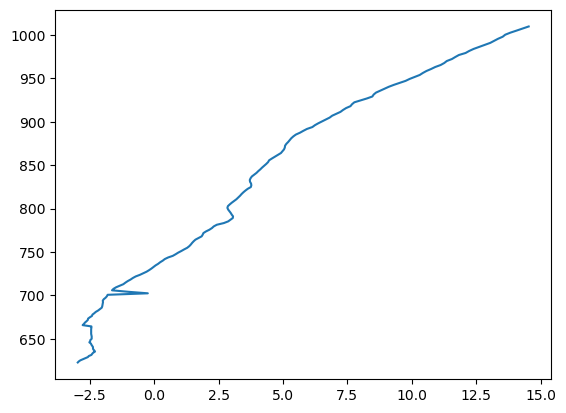

In [8]:
#Using the Dataframe you can make the plot this way
plt.plot(df['Temperature'],df['Pressure'])

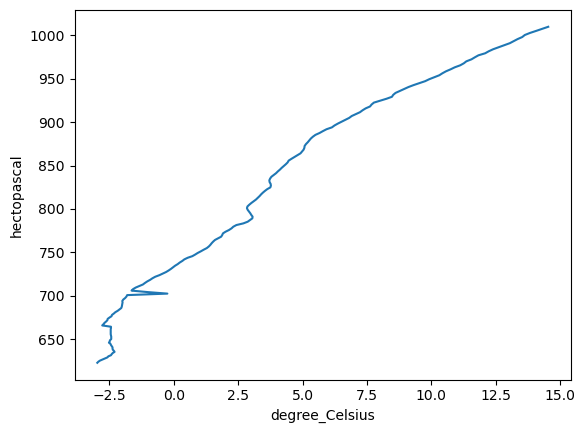

In [9]:
#Using the variables you can make the plot this way
plt.plot(T,p) 

Note the variables have units associated with them and they are used as automatic labels while the dataframe method does not have this. This will be important later. Both ways of handling the data will be useful.

This looks a bit quick and dirty, pressure is goign the wrong way and axes are not the easiest for a human to understand, so let's make it look a bit nicer, using `matplotlib`. 

We then save the figure as a `.jpg` and `.pdf` for future use. Note that the `savefig` function needs to be in the same cell as the code to create the plots in order for the saved files to not be blank! 

Consider which format you want your plots to be saved as and be aware of compression issues with photo formats. Take care not to overwrite a plot by reusing filenames without realising. Due to their use of vector graphics, PDFs work well. However, conventional word processors struggle with importing graphics as PDFs (though it is theoretically possible). If you use $\LaTeX$, PDFs can be used as graphics with minimal fuss.

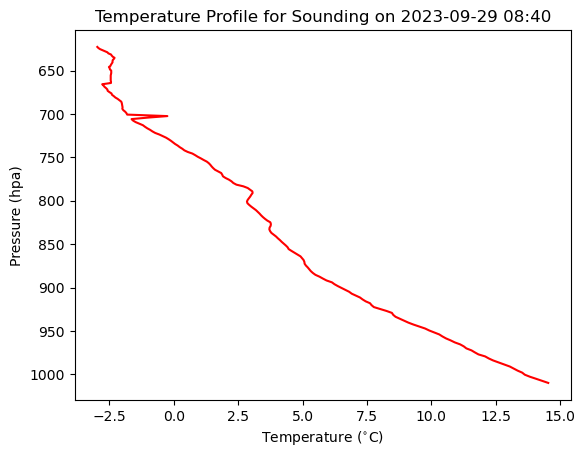

In [10]:
#setup plot axes
fig,ax = plt.subplots()
plt.plot(df['Temperature'],df['Pressure'],'r-') #plot as a green line
plt.xlabel(r'Temperature ($^{\circ}$C) ') 
plt.ylabel('Pressure (hpa)')
ax.invert_yaxis() #pressure descreases with height
plt.title('Temperature Profile for Sounding on '+utc_time.strftime('%Y-%m-%d %H:%M')) #add title, using the date time format codes again

#save this figure as a jpg and pdf
plt.savefig('output/temp.jpg',bbox_inches='tight')

Once the plots are saved, you can select them in the navigation bar and right click (ctrl click on mac) and download the file to your desktop.

Let's go wild and plot the temperature and humidty for this profile at the same time and add a grid to make interpretation easier.

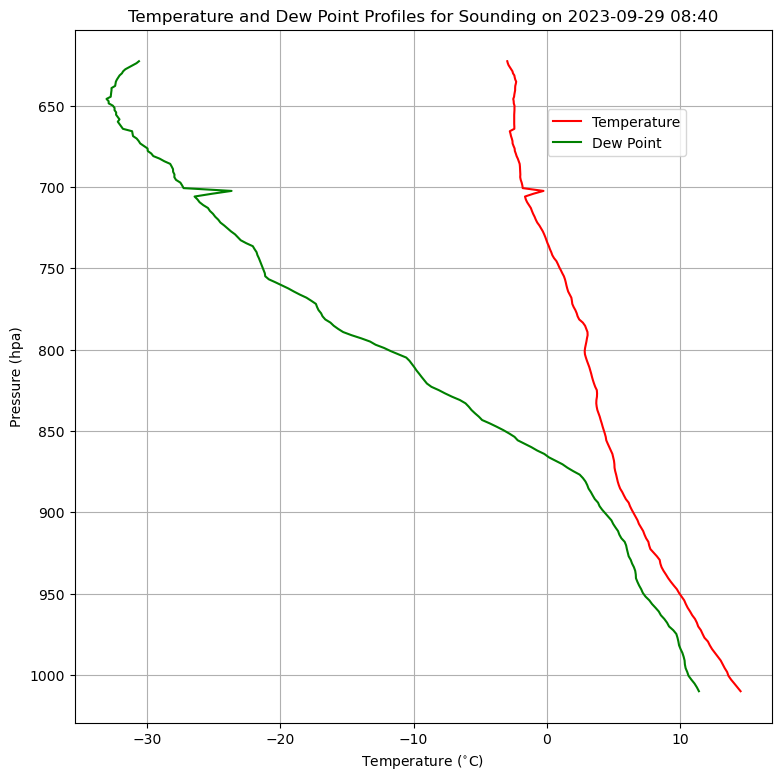

In [11]:
#setup plot axes
fig,ax = plt.subplots(figsize=(9, 9))  #Changes the size of the figure
                      
plt.plot(df['Temperature'],df['Pressure'],'r-',label='Temperature') #plot as a red line

plt.plot(df['Dew_point'],df['Pressure'],'g-',label='Dew Point') #plot as a green line


plt.xlabel(r'Temperature ($^{\circ}$C) ') 
plt.ylabel('Pressure (hpa)')

ax.invert_yaxis() #pressure descreases with height
ax.grid() #add grid

plt.title('Temperature and Dew Point Profiles for Sounding on '+utc_time.strftime('%Y-%m-%d %H:%M')) #add title, using the date time format codes again



#add a legend and save the figures as jpg and pdf
fig.legend(loc=(0.7,0.8),ncol=1)
plt.savefig('output/both.jpg',bbox_inches='tight')

## Making Skew T Plots<a name="sec3"></a>

The section above was good for looking at the data but now it would be good to do some more quantitative analysis.
To do this we will make skew T log-P plot using the functions in [MetPy](https://unidata.github.io/MetPy/latest/#).

To start will be continue to use the data from the profile already read in above.

### Basic Skew-T Plotting
The Skew-T (log-P) diagram is a standard way to view radiosonde data. The y-axis is height in pressure coordinates and the x-axis is temperature. The y coordinates are plotted on a logarithmic scale and the x coordinate system is skewed. An explanation of skew-T interpretation is in the Course Handbook. Here we will plot one that can be used for analysis or publication.

Once the data has been read in the most basic skew-T can be plotted with only five lines of Python. These lines perform the following tasks:
1. Create a Figure object and set the size of the figure.
2. Create a SkewT object
3. Plot the pressure and temperature (note that the pressure, the independent variable, is first even though it is plotted on the y-axis).
4. Plot the pressure and dewpoint temperature.
5. Plot the wind barbs at the appropriate pressure using the u and v wind components.


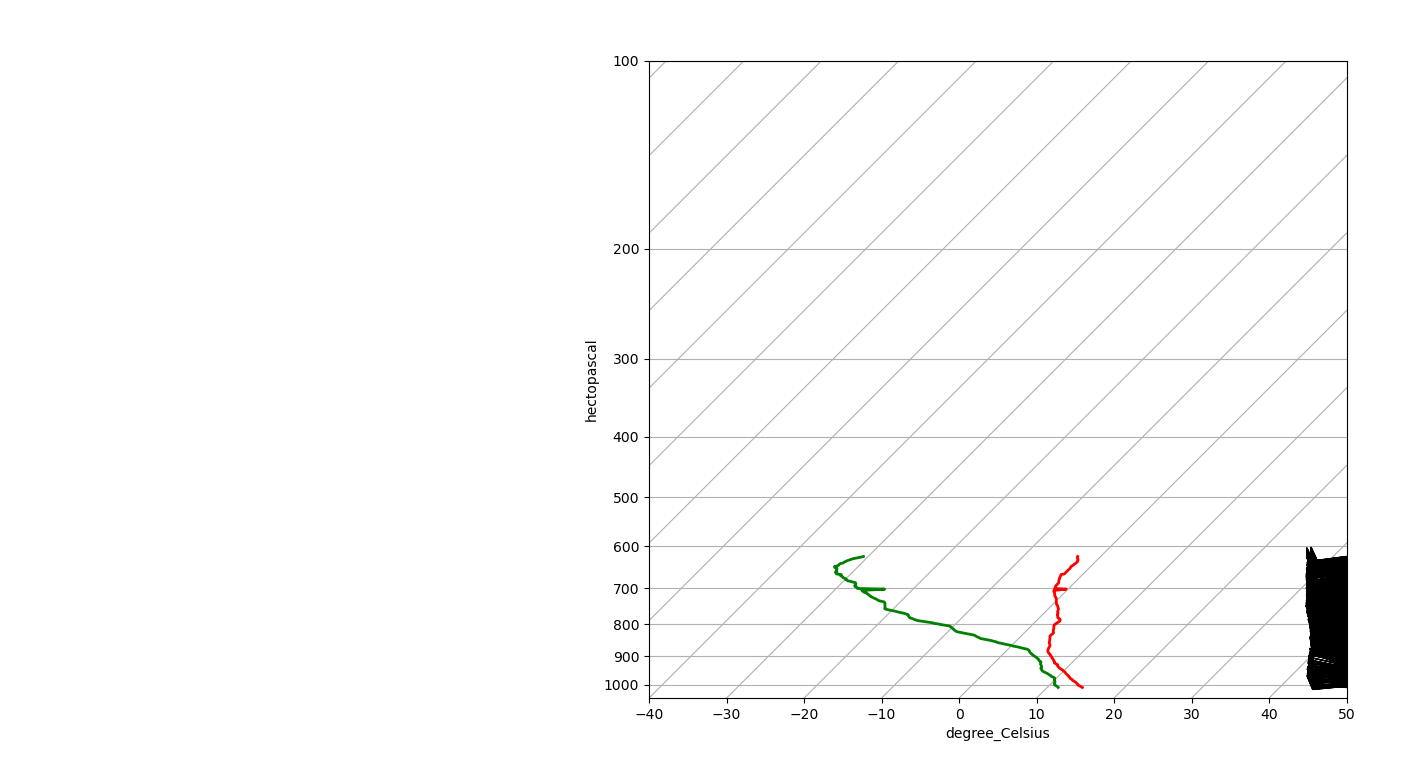

In [12]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig,rotation=45) #Make temperature skew 45 degree instead of the default 30 degrees

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

OK. So that made a skew-T log-P plot but it is hard to see our profile.  Lets make a few adjustments.

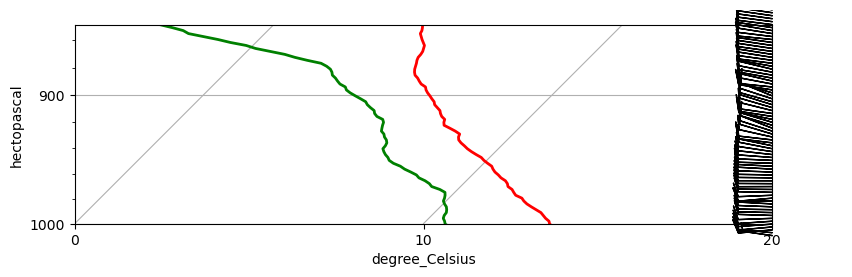

In [13]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig,rotation=45)
skew.ax.set_ylim(1000, 850) #Changes Pressure limits
skew.ax.set_xlim(0, 20) #Changes temperature axis limit
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

### Advanced Skew-T Plotting
Fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are useful when performing further analysis on the Skew-T diagram. Often the 0C isotherm is also emphasized 

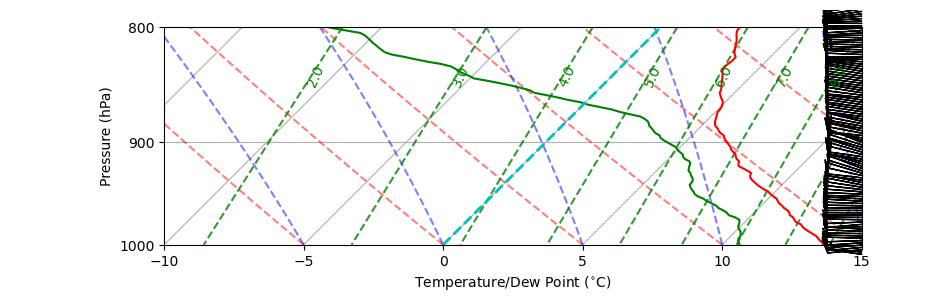

In [14]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 5))

skew = SkewT(fig,rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

skew.ax.set_ylim(1000, 800) #Changes Pressure limits

xmin=-10 # Min Temp
xmax= 15 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio = np.linspace(0.002, 0.032, num=31).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(850* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,850),rotation=66,c='g',fontsize=10)
    
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')

plt.ylabel(r'Pressure (hPa)')



# Show the plot
plt.show()



### Adding a Hodogragh

A hodograph is a polar representation of the wind profile measured by the rawinsonde. Winds at different levels are plotted as vectors with their tails at the origin, the angle from the vertical axes representing the direction, and the length representing the speed. The line plotted on the hodograph is a line connecting the tips of these vectors, which are not drawn.

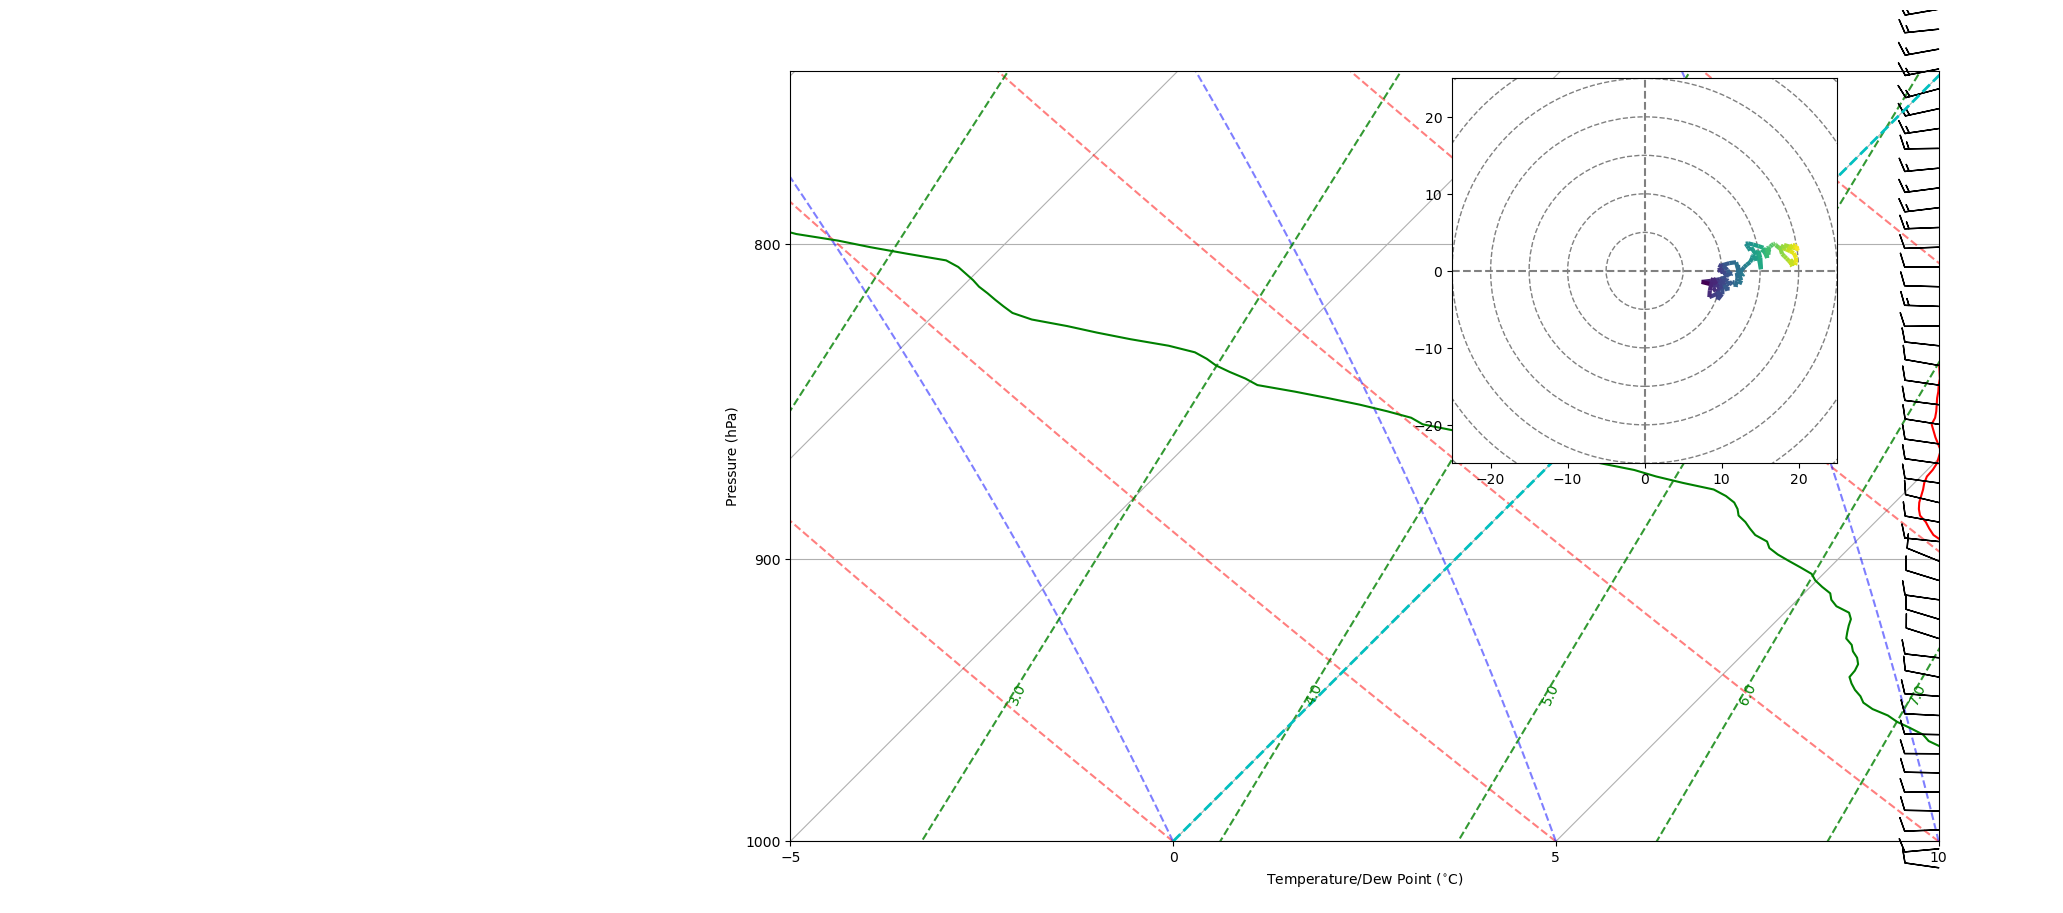

In [15]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(15, 10))

skew = SkewT(fig,rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[0:-1:3], u[0:-1:3], v[0:-1:3]) #plot every third wind point

skew.ax.set_ylim(1000, 750) #Changes Pressure limits

xmin=-5 # Min Temp
xmax= 10 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio = np.linspace(0.002, 0.032, num=31).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=66,c='g',fontsize=10)
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '50%', '50%', loc='upper right')
h = Hodograph(ax_hod, component_range=25.)
h.add_grid(increment=5)
h.plot_colormapped(u, v, WS)  # Plot a line colored by wind speed


# Show the plot
plt.show()



## Digging Deeper into the Data<a name="sec4"></a>

Now that we have made a nifty skew-T log-P plot we should see what else we can calculate from the data.


Often times we will want to calculate some thermodynamic parameters of a sounding. These can be estimated by hand using the plots above but he MetPy calc module has many such calculations already implemented!

    Lifting Condensation Level (LCL) - The level at which an air parcel’s relative humidity becomes 100% when lifted along a dry adiabatic path.

    Parcel Path - Path followed by a hypothetical parcel of air, beginning at the surface temperature/pressure and rising dry adiabatically until reaching the LCL, then rising moist adiabatially.


In [16]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print('The LCL is at', lcl_pressure, 'and', lcl_temperature)

# Calculate the parcel path profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

The LCL is at 963.5558647196784 hectopascal and 10.705296760564465 degree_Celsius


Lets add these to the skew-T log-P diagram

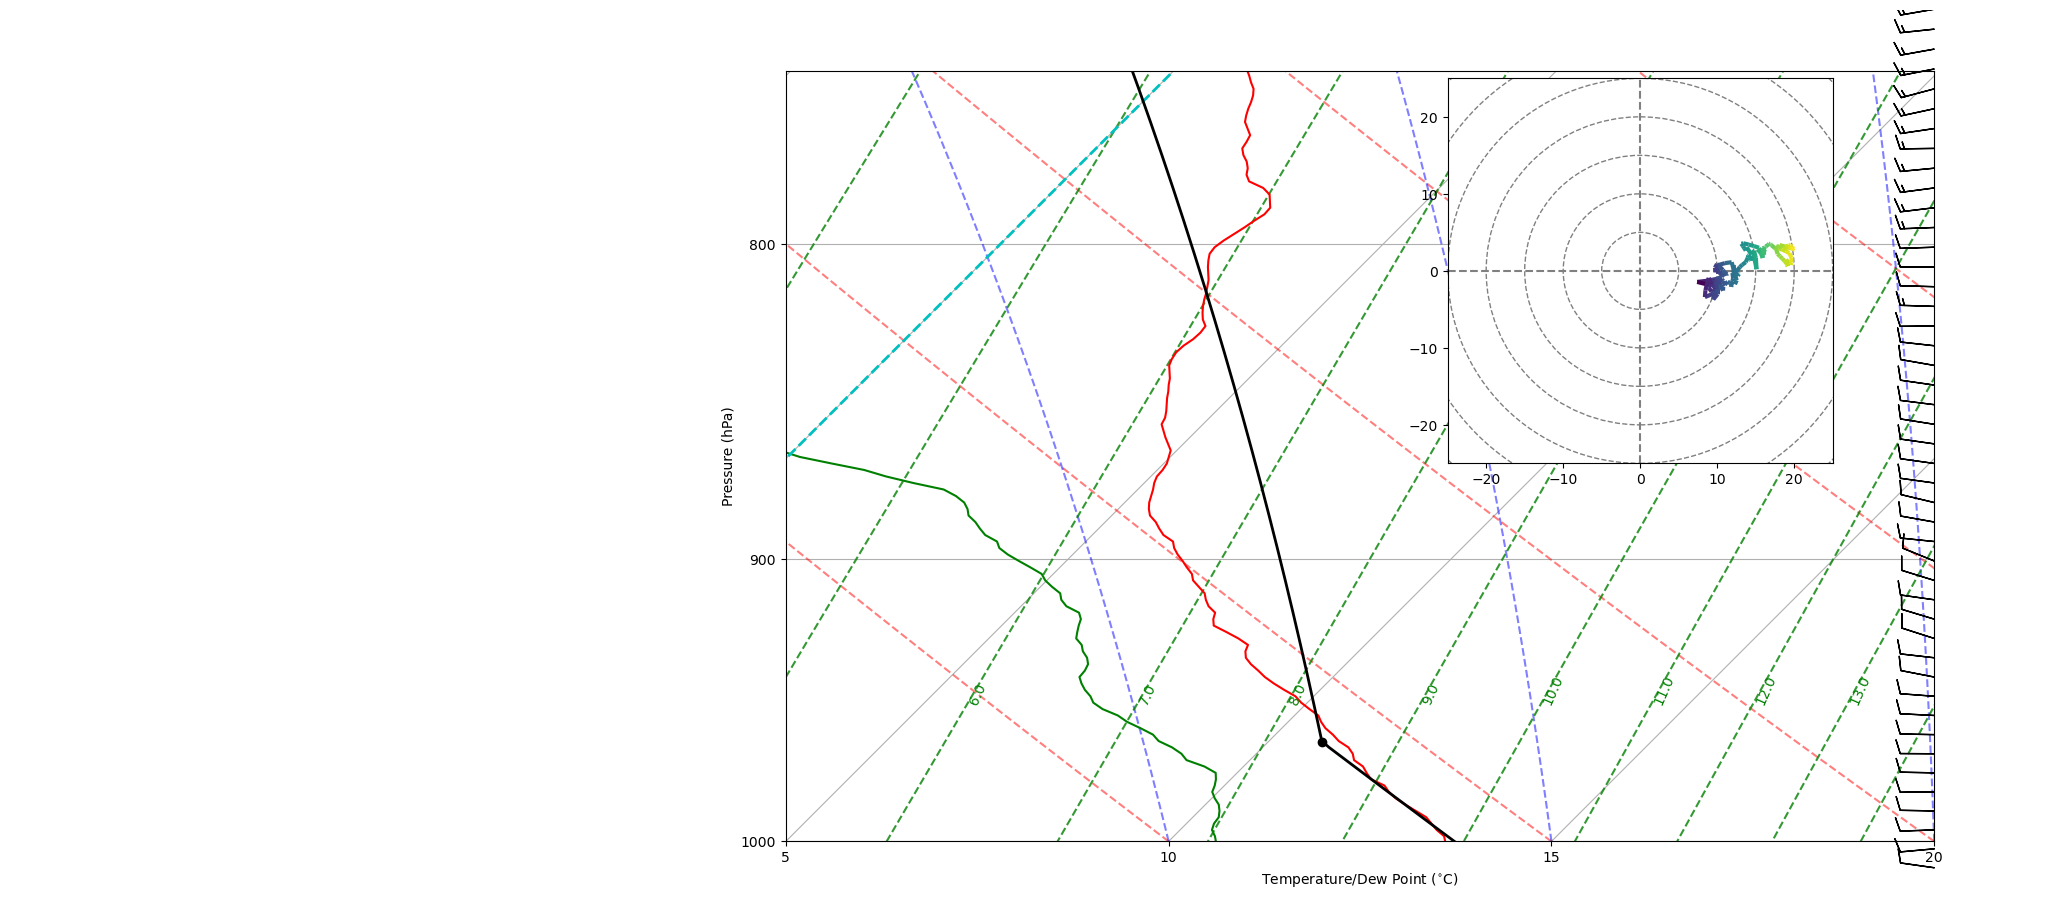

In [17]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(20, 10))

skew = SkewT(fig,rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[0:-1:3], u[0:-1:3], v[0:-1:3]) #plot every third wind point

skew.ax.set_ylim(1000, 750) #Changes Pressure limits

xmin=5 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio = np.linspace(0.003, 0.032, num=30).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=66,c='g',fontsize=10)
    

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile path as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)
    

plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '50%', '50%', loc='upper right')
h = Hodograph(ax_hod, component_range=25.)
h.add_grid(increment=5)
h.plot_colormapped(u, v, WS)  # Plot a line colored by wind speed


# Show the plot
plt.show()



You can see that the location of the LCL and the pacel path do not quote match up with the observations. This is most lilkey due to the initial values of the observed profile being biased in some way or poorly representative of the near surface air. In this case you can start the parcel and LCL calculation with a different value. These differences may tell us something interesting about the boundary layer.

The LCL is at 950.7516225946421 hectopascal and 9.625357359302086 degree_Celsius


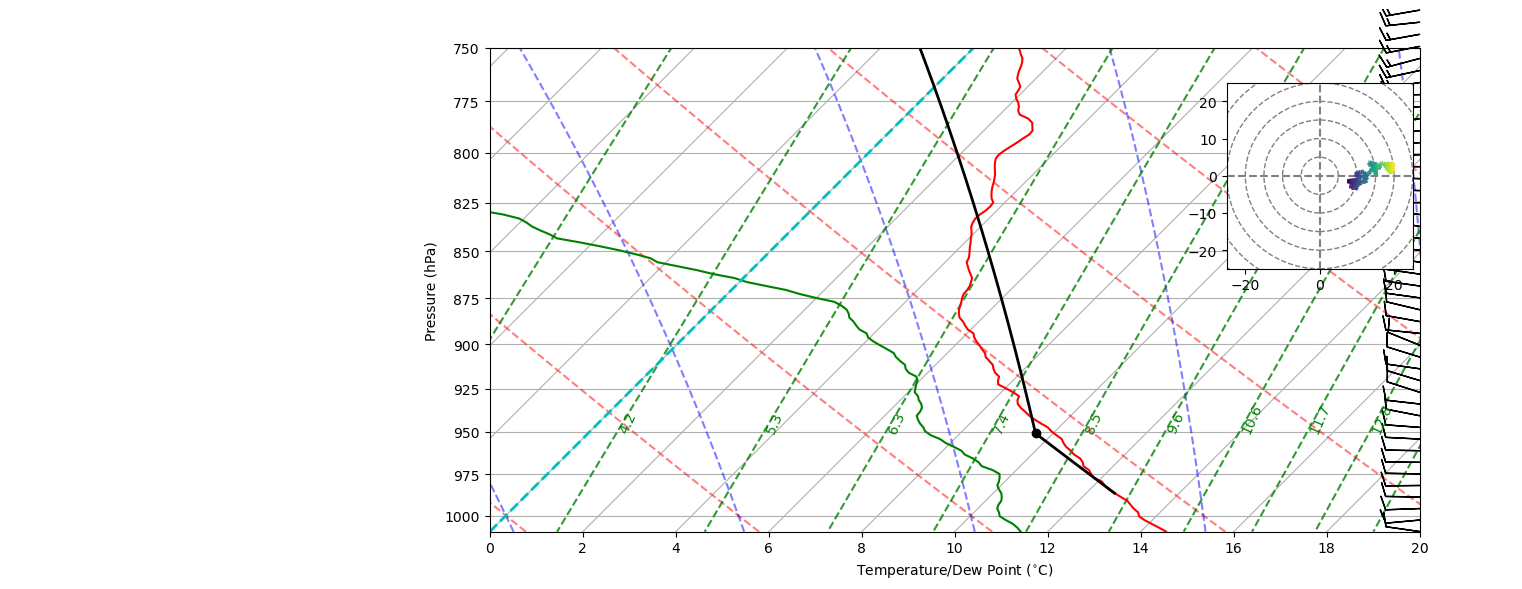

In [18]:
# Calculate the LCL with a value from higher up.
i=10

lcl_pressure, lcl_temperature = mpcalc.lcl(p[i], T[i], Td[i],100)

print('The LCL is at', lcl_pressure.to(units.hPa), 'and', lcl_temperature)

p_parcel = p[i:]

# Calculate the parcel path profile with a starting value from higher up.
parcel_prof = mpcalc.parcel_profile(p_parcel, T[i], Td[i]).to('degC')


#Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(12, 15))

skew = SkewT(fig,rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[0:-1:3], u[0:-1:3], v[0:-1:3]) #plot every third wind point

skew.ax.set_ylim(1010, 750) #Changes Pressure limits

xmin=0 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(2))  #Change X tick interval to 2 degrees C
skew.ax.yaxis.set_major_locator(MultipleLocator(25))  #Change Y tick interval to 25hPa



# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio = np.linspace(0.001, 0.032, num=30).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=66,c='g',fontsize=10)
    

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile path as a black line
skew.plot(p_parcel, parcel_prof, 'k', linewidth=2)
    

plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '20%', '50%', loc='upper right')
h = Hodograph(ax_hod, component_range=25.)
h.add_grid(increment=5)
h.plot_colormapped(u, v, WS)  # Plot a line colored by wind speed

#save this figure as a jpg and pdf
plt.savefig('output/skewt_with_lcl_parcelpath.jpg',bbox_inches='tight', dpi=300)

This function calculates the wet-bulb temperature using the Normand method. 
The LCL is computed, and that parcel brought down to the starting pressure along a moist adiabat.
The Normand method (and others) are described and compared by [Knox2017](https://journals.ametsoc.org/view/journals/bams/98/9/bams-d-16-0246.1.xml).

In [19]:
# Calculate the Wet Bulb Temperature

pressure = [p[0].magnitude] * units.hPa # Silly thing with pressure that makes the calculation work.

wet_bulb_temperature = np.round(mpcalc.wet_bulb_temperature(pressure, T[0], Td[0]),1) 

print('The Wet Bulb Temperature of the Surface is ', wet_bulb_temperature)

The Wet Bulb Temperature of the Surface is  12.7 degree_Celsius


Similarly, you can calculate the wet-bulb temperature at other levels of the atmosphere (heights).

You should make sure this makes sense on the skew-T log-P diagram.

In [20]:
# Calculate the Wet Bulb Temperature

index=17

Level_Height=z[index]

Level_Pressure=p[index]

pressure = [p[index].magnitude] * units.hPa # Silly thing with pressure that makes the calculation work.

wet_bulb_temperature = np.round(mpcalc.wet_bulb_temperature(pressure, T[index], Td[index]),1) 

print('The Wet Bulb Temperature at the ', Level_Height,'(',Level_Pressure,') level is ', wet_bulb_temperature)

The Wet Bulb Temperature at the  400 meter ( 970.09 hectopascal ) level is  10.1 degree_Celsius
